# Content

    1. Task 2.1 word embedding
        1.1 Creating vocabulary and datasets
        1.2 Creating "context/label" datasets
        1.3 MLP to create embeddings
        1.4 Training and performance
        1.5 Save embeddings to a .pt file
    2. Task 2.2 be and have conjugation
        2.1 Creating datasets
        2.2 Simple attention
        2.3 MLP with attention model
        2.4 MY RNN Model
        2.5 Training and performance of MODEL_ATTENTION.pt
        2.6 Training and performance of MODEL_RNN.pt
    3. Task 2.3 Text generation in main file

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchtext
import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from utils import train, set_device, compute_accuracy
import math
from IPython.display import display, clear_output
seed = 265
torch.manual_seed(seed)

# 1. Task 2.1

## 1.1 Creating vocabulary and datasets

In [2]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [3]:
# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + "words_train.pt"):
    words_train = torch.load(PATH_GENERATED + "words_train.pt")
    words_val = torch.load(PATH_GENERATED + "words_val.pt")
    words_test = torch.load(PATH_GENERATED + "words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('./data_train/')
    lines_books_val = read_files('./data_val/')
    lines_books_test = read_files('./data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + "words_train.pt")
    torch.save(words_val , PATH_GENERATED + "words_val.pt")
    torch.save(words_test , PATH_GENERATED + "words_test.pt")



# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED + VOCAB_FNAME)
    


# ------------------------ Quick analysis ------------------------------
VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Total number of words in the validation dataset:   ", len(words_val))
print("Total number of words in the test dataset:         ", len(words_test))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)

freqs = count_freqs(words_train, vocab)
print("occurences:\n", [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))])

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152
Number of distinct words in the training dataset:   52105
Number of distinct words kept (vocabulary size):    1880
occurences:
 [(433907, '<unk>'), (182537, ','), (151278, 'the'), (123727, '.'), (82289, 'and'), (65661, 'of'), (62763, 'to'), (49230, 'a'), (41477, 'in'), (31052, 'that'), (37167, 'he'), (29046, 'was'), (26508, 'his'), (26354, 'it'), (20862, 'with'), (20159, 'had'), (19965, 'is'), (15692, 'not'), (16593, 'as'), (15705, 'on'), (14464, 'him'), (15317, 'for'), (15838, 'at'), (15952, 'you'), (13255, 'be'), (12698, 'her'), (12798, 's'), (11924, 'which'), (11808, '!'), (11740, 'all'), (10338, '?'), (10205, 'have'), (10405, 'from'), (13251, 'but'), (11464, 'this'), (9439, 'by'), (11496, 'they'), (8797, 'said'), (8800, 'are'), (11055, 'she'), (9537, 'one'), (8219, 'were'), (8564, 'who'), (8345, 'so'), (9409

## 1.2 Creating "context/label" datasets

In [4]:
# context size for this task 
CONTEXT_SIZE = 3


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target
        c = txt[i:i + context_size] + txt[i + context_size + 1:i + context_size + 1 + context_size]
        
        if len(c) == 6:
            targets.append(t)
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

In [5]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

## 1.3 MLP to create embeddings

In [6]:
class MyMLP_train(nn.Module):
    
    def __init__(self, vocab_size=1880, embedding_dim=10, context_size=CONTEXT_SIZE*2):
        super().__init__()
        
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
            
        # Regular MLP
        self.fc1 = nn.Linear(embedding_dim*context_size, 128)
        self.fc2 = nn.Linear(128, VOCAB_SIZE)

    def forward(self, x):
        # x is of shape (N, context_size) but contains integers which can
        # be seen as equivalent to (N, context_size, vocab_size) since one hot
        # encoding is used under the hood
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)
        
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)
        
        out = self.fc2(out)
        return out

## 1.4 Training and performance

In [7]:
torch.manual_seed(seed)
device = set_device()


MODEL_FNAME = "model.pt"

batch_size=512
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

model = MyMLP_train()

if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained model
    model = torch.load(PATH_GENERATED + MODEL_FNAME)
    model.to(device)
else:
    # Or train the model...
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    n_epochs=30

    train(n_epochs, optimizer, model, loss_fn, train_loader)
    # ... and save it
    torch.save(model.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(model, train_loader)
acc_val = compute_accuracy(model, val_loader)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)

On device cpu.
On device cpu.
On device cpu.
Training Accuracy:     0.3727
Validation Accuracy:   0.3668


## 1.5 Save embeddings to a .pt file

In [8]:
# Load the model.pt file
model_state_dict = torch.load(PATH_GENERATED + "model.pt")

# Extract the embedding weights
embedding_weights = model_state_dict.embedding

# Save the embedding weights to a new .pt file
torch.save(embedding_weights, PATH_GENERATED + "embeddings.pt")

In [9]:
embedding = torch.load(PATH_GENERATED + "embeddings.pt")

In [10]:
embedding.weight.data

tensor([[-0.7113, -0.4291,  0.3201,  ...,  0.1893,  0.3876,  0.4825],
        [-0.7197,  0.4194,  1.2058,  ...,  0.9158, -0.9787, -0.5259],
        [ 0.7245, -0.6136, -1.0676,  ...,  1.4184, -0.2769,  0.3635],
        ...,
        [ 1.0629, -0.6368,  1.3616,  ...,  0.3551,  1.6261, -0.9608],
        [-0.2361,  0.3703, -0.0491,  ...,  0.4575,  0.6760,  0.7526],
        [ 2.0310,  1.2806,  0.0027,  ...,  1.5835, -0.6891, -0.6740]])

In [11]:
embeddings_tsv = embedding
embeddings_tsv = embeddings_tsv.weight.detach().numpy()
df = pd.DataFrame(embeddings_tsv)
df

,0,1,2,3,4,5,6,7,8,9
0,-0.711318,-0.429117,0.320072,-0.438549,-0.072789,-0.490328,-0.506588,0.189302,0.387606,0.482511
1,-0.719662,0.419366,1.205772,-0.165893,-0.055032,-0.632643,0.950606,0.915822,-0.978738,-0.525862
2,0.724457,-0.613590,-1.067608,-1.207475,-0.481757,0.479321,1.395973,1.418402,-0.276932,0.363500
3,-0.592553,0.980284,2.082150,-0.387613,-0.371271,0.966273,0.779362,0.414348,0.338546,-1.655101
4,0.885879,0.475946,1.941342,0.287676,-1.126295,-0.019672,0.710776,1.099598,-0.093946,0.546516
...,...,...,...,...,...,...,...,...,...,...
1875,1.017892,-1.762980,0.152583,1.334535,1.501916,-0.553635,0.041718,0.443957,0.728637,0.201682
1876,-1.327927,-0.450362,-0.855280,1.293782,1.964983,-0.170144,-0.857106,2.781407,1.358132,0.128895
1877,1.062906,-0.636836,1.361603,-0.432130,-1.851287,1.320264,-3.164718,0.355052,1.626089,-0.960758
1878,-0.236145,0.370334,-0.049119,0.130092,-0.378512,-1.077464,-0.270208,0.457543,0.676001,0.752626


In [12]:
df = df.to_csv(PATH_GENERATED + "embeddings.tsv",sep="\t", header=None, index=False)

In [13]:
pd_vocab = []
for word in vocab.lookup_tokens(range(VOCAB_SIZE)):
    pd_vocab.append(word)
#pd_vocab = pd.DataFrame(pd_vocab)
#pd_vocab = pd_vocab.to_csv(PATH_GENERATED + "vocab.tsv",sep="\t", header=None, index=False)

In [14]:
# Load vocabulary and embeddings
vocab_no = pd_vocab
embeddings = torch.load(PATH_GENERATED + 'embeddings.pt')
embeddings = embeddings.weight

# Normalize embeddings
norms = embeddings.norm(dim=1, keepdim=True)
embeddings = embeddings.div(norms)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings.detach().numpy())

# Find most similar words for some target words
target_words = 'child'
top_k = 10
for word in vocab_no:
    index = vocab_no.index(target_words)
    similarity_scores = similarity_matrix[index]
    similar_words = [vocab_no[i] for i in similarity_scores.argsort()[-top_k-1:-1][::-1]]
print(f"Top {top_k} words similar to '{target_words}': {similar_words}")


Top 10 words similar to 'child': ['boy', 'dog', 'maid', 'servant', 'lad', 'stranger', 'girl', 'peasant', 'porter', 'gardener']


# 2. Task 2.2 be and have conjugation

In [15]:
conjugation_mapping = {
    'be': 0, 'am': 1, 'are': 2, 'is': 3, 'was': 4, 'were': 5,
    'been': 6, 'being': 7, 'have': 8, 'has': 9, 'had': 10, 'having': 11
}
re_map = {0: 24, 1: 122, 2: 38, 3: 16, 4: 11, 5: 41, 6: 56, 7: 155, 8: 31, 9: 68, 10: 15, 11: 212}


In [16]:
#creates (context, verb) tuples to be used for training validation and testing
def create_dataset_con(text, vocab, conjugation_map, context_size=6):
    context_all = []
    target = []
    for n, i in enumerate (text):
        if i in conjugation_map.keys() and n >= context_size and (len(text) - n) > context_size:
            context = []
            start = max(0, n-context_size)
            end = min(len(text), n + context_size +1)

            for j in range(start, end):
                if j != n and j<len(text):
                    word = text[j]
                    if word in vocab:
                        context.append(vocab[word])
                    else:
                        context.append(vocab['<unk>'])
            context_all.append(torch.tensor(context))
            if i in vocab:
                target_verb_index = vocab[i]
                target.append(conjugation_map[i])
            else:
                target_verb_index = vocab['<unk>']
                target.append(target_verb_index)

    context_all = torch.stack(context_all)
    target = torch.tensor(target)
    return(context_all, target)


# Creates datasets used for training, validation and testing

In [17]:
criterion = torch.nn.CrossEntropyLoss()

#prepare training data
context_all_3, target_3 = create_dataset_con(words_train, vocab, conjugation_mapping,context_size=3)
train_dataset_3 = TensorDataset(context_all_3, target_3)
dataloader_3 = DataLoader(train_dataset_3, batch_size=32, shuffle=False)

#prepare val_data
val_con_3, val_target_3 = create_dataset_con(words_val, vocab, conjugation_mapping, context_size=3) 
val_dataset_3 = TensorDataset(val_con_3,val_target_3) 
val_dataloader_3 = DataLoader(val_dataset_3, batch_size=32, shuffle=False)

#prepare test_data
test_con_3, test_target_3 = create_dataset_con(words_test, vocab, conjugation_mapping, context_size=3) 
test_dataset_3 = TensorDataset(test_con_3,test_target_3) 
test_dataloader_3 = DataLoader(test_dataset_3, batch_size=32, shuffle=False)

# Simple MLP

In [18]:
class simpleMLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, max_len):
            super(simpleMLP, self).__init__()
            self.embedding = nn.Embedding(num_embeddings=1880, embedding_dim=embedding_dim)
            self.fc1 = nn.Linear(max_len*embedding_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            

    def forward(self, x):
        x = self.embedding(x)
        x = x.reshape(x.shape[0], -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# MLP with attention

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_len=256):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))


    def forward(self, x):
        return x + self.pe[:x.size(0), :]
    

In [20]:
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads
        
        self.query_layers = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(num_heads)])
        self.key_layers = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(num_heads)])
        self.value_layers = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(num_heads)])

    def forward(self, x):
        concat_heads = []
        for i in range(self.num_heads):
            queries = self.query_layers[i](x)
            keys = self.key_layers[i](x)
            values = self.value_layers[i](x)
            scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.d_k)
            attn = torch.softmax(scores, dim=-1)
            head_output = torch.matmul(attn, values)
            concat_heads.append(head_output)
        concat_output = torch.cat(concat_heads, dim=-1)
        return concat_output


In [21]:
class MLPWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, max_len, num_heads):
        super(MLPWithAttention, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=1880, embedding_dim=embedding_dim)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_len)
        self.attention = SimpleMultiheadAttention(embedding_dim, num_heads)
        self.fc1 = nn.Linear(max_len*embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.attention(x)
        x = x.reshape(x.shape[0], -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# RNN LSTM Model

In [22]:
class LSTMConjugationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(LSTMConjugationModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # We take the output from the last time step
        x = lstm_out[:, -1, :]
        x = self.fc(x)
        return x

# Simple trainingloop

In [23]:


def train_model(dataloader, model, criterion, optimizer, epoch):
    model.train() 
    total_loss = 0
    for context, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(context) 
        loss = criterion(outputs, targets)
        loss.backward() 
        optimizer.step()  
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss



# Checks validation accuracy and loss of current model

In [24]:



def loss_validation(data, model, criterion):
    all_preds = torch.tensor([]).to(device)  
    all_labels = torch.tensor([]).to(device)
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for context, target in data:
            context, target = context.to(device), target.to(device)  
            pred = model(context)
            loss = criterion(pred, target)
            total_loss += loss.item()

            _, predicted = torch.max(pred, 1)
            all_preds = torch.cat((all_preds, predicted.float()), dim=0)
            all_labels = torch.cat((all_labels, target.float()), dim=0)

    correct = (all_preds == all_labels).sum().item()
    accuracy = 100 * correct / all_labels.size(0)
    
    return all_labels, all_preds, accuracy, (total_loss / len(data))  




# Main trainingloop
    -runs train and val epoch times
    -plots training and validationloss per epoch
    -stops if validation accuracy does not decrease over 3 epochs 
    -saves the one with the lowest validationloss

In [25]:

ALL_MODELS = './lstm_models/'
def training_loop(model, train_dataloader, val_dataloader, criterion, optimizer, name, epochs=10):
    pations = 3
    fig, ax = plt.subplots(figsize=(10, 5)) 
    training_losses = []
    validation_losses=[]
    best_val_loss = 10
    if not os.path.exists(ALL_MODELS):
        os.makedirs(ALL_MODELS)
    for epoch in range(epochs):
        train_loss = train_model(train_dataloader, model, criterion, optimizer, epoch)
        _,_,_,validation_loss = loss_validation(val_dataloader, model, criterion)
        
        
        if  validation_loss < best_val_loss:
            best_val_loss = validation_loss
            pations = 3
            torch.save(model,ALL_MODELS + name + '.pth')
        else:
            pations -= 1
            if pations == 0:
                print(f'stopped at epoch {epoch} as validation did not imporove over 3 epochs')
                break

        training_losses.append(train_loss)
        validation_losses.append(validation_loss)

        ax.plot(range(1, epoch + 2), training_losses, 'bo-', label='Training Loss')
        ax.plot(range(1, epoch + 2), validation_losses, 'ro-', label='Validation Loss')

        if epoch == 0:
            ax.legend()
            ax.set_title('Training and Validation Losses Per Epoch')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
        
        display(fig)    
        clear_output(wait=True) 

    plt.close(fig)



In [27]:
def model_selection_SIMPLE_MLP():
    embedding_dim = [100, 200]
    hidden_dim = [128, 256]
    learning_rate = [0.001, 0.0001]
    for em_dim in embedding_dim:
        for hid_dim in hidden_dim:
            for lr in learning_rate:
                    model = simpleMLP(embedding_dim=em_dim, hidden_dim=hid_dim, output_dim=12, max_len=2*3)            
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    training_loop(model, dataloader_3, val_dataloader_3, criterion, optimizer, f'SIMPLE_MLP_{em_dim}_{hid_dim}_{lr}',epochs=30)
                    


model_selection_SIMPLE_MLP()

stopped at epoch 5 as validation did not imporove over 3 epochs


# Model selction for MLP with attention

In [154]:
def model_selection_MLP():
    embedding_dim = [100, 200]
    hidden_dim = [128, 256]
    num_heads = [4, 10]
    learning_rate = [0.001, 0.0001]
    for em_dim in embedding_dim:
        for hid_dim in hidden_dim:
            for num_head in num_heads:
                for lr in learning_rate:
                        model = MLPWithAttention(embedding_dim=em_dim, hidden_dim=hid_dim, output_dim=12, max_len=2*3, num_heads=num_head)            
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                        training_loop(model, dataloader_3, val_dataloader_3, criterion, optimizer, f'MLP_{em_dim}_{hid_dim}_{num_head}_{lr}',epochs=30)
                       
model_selection_MLP()


stopped at epoch 6 as validation did not imporove over 3 epochs


# Model selection for LSTM 

In [155]:
def model_selection_LSTM():
    lstm_layers = [2,4,6]
    hidden_dim = [128, 256]
    dropout = [0.2, 0.4]
    learning_rate = [0.001, 0.0001]
    for layers in lstm_layers:
        for dim in hidden_dim:
            for drop in dropout:
                for lr in learning_rate:
                        model = LSTMConjugationModel(1880, 200, dim, 12, layers, drop)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                        training_loop(model, dataloader_3, val_dataloader_3, criterion, optimizer,f'LSTM_{layers}{dim}{drop}{lr}' ,epochs=30)

model_selection_LSTM()



stopped at epoch 6 as validation did not imporove over 3 epochs


# Loades the treained models and finds the best one to test on testdata

In [125]:
def check_performance_SIMPLE_MLP():
    embedding_dim = [100, 200]
    hidden_dim = [128, 256]
    learning_rate = [0.001, 0.0001]
    results = []
    for em_dim in embedding_dim:
        for hid_dim in hidden_dim:
            for lr in learning_rate:
                model_path = ALL_MODELS + f'SIMPLE_MLP_{em_dim}_{hid_dim}_{lr}.pth'
                if os.path.exists(model_path):
                        model = torch.load(model_path)
                        model.eval()
                        val_loss, val_accuracy, accuracy,_ = loss_validation(val_dataloader_3, model, criterion)


                        results.append((accuracy, f'SIMPLE_MLP_{em_dim}_{hid_dim}_{lr}'))
                        #print(f"Layers: {layers}, Hidden: {dim}, Dropout: {drop}, LR: {lr}, Loss: {val_loss}, Accuracy: {val_accuracy}")
                else:
                        print(f"Model file not found: {model_path}")
    best_result = max(results, key=lambda x: x[0])
    print (f'the best model on validation data was with {best_result[1]} and gave an accuracy of {best_result[0]}')

    model = torch.load(ALL_MODELS + best_result[1] +'.pth')
    model.eval()
    val_loss, val_accuracy, accuracy,_ = loss_validation(test_dataloader_3, model, criterion)
    print (f'the best model on test data gave an accuracy of {accuracy}')
    return model

check_performance_SIMPLE_MLP()
    

the best model on validation data was with SIMPLE_MLP_100_128_0.0001 and gave an accuracy of 59.42084942084942
the best model on test data gave an accuracy of 51.227701993704095


simpleMLP(
  (embedding): Embedding(1880, 100)
  (fc1): Linear(in_features=600, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

# checks accuracy for the LSTM models 

In [103]:

def check_performance_LSTM():
    lstm_layers = [2, 4, 6]
    hidden_dim = [128, 256]
    dropout = [0.2, 0.4]
    learning_rate = [0.01, 0.001, 0.0001]
    results = []

    for layers in lstm_layers:
        for dim in hidden_dim:
            for drop in dropout:
                for lr in learning_rate:
                        
                        model_path = ALL_MODELS + f'{layers}{dim}{drop}{lr}.pth'
                        if os.path.exists(model_path):
                            model = torch.load(model_path)
                            model.eval()
                            _, _, accuracy,_ = loss_validation(val_dataloader_3, model, criterion)
                            results.append((accuracy, f'{layers}{dim}{drop}{lr}'))
                        else:
                            print(f"Model file not found: {model_path}")
                            
    best_result = max(results, key=lambda x: x[0])
    print (f'the best model on validation data was with {best_result[1]} and gave an accuracy of {best_result[0]}')

    model = torch.load(ALL_MODELS + best_result[1] +'.pth')
    model.eval()
    val_loss, val_accuracy, accuracy,_ = loss_validation(test_dataloader_3, model, criterion)
    print (f'the best model on test data gave an accuracy of {accuracy}')
    return model

check_performance_LSTM()


the best model on validation data was with 62560.40.001 and gave an accuracy of 66.98841698841699
the best model on test data gave an accuracy of 59.01364113326338


LSTMConjugationModel(
  (embedding): Embedding(1880, 200)
  (lstm): LSTM(200, 256, num_layers=6, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=256, out_features=12, bias=True)
)

In [127]:
def check_performance_MLP():
    embedding_dim = [100, 200]
    hidden_dim = [128, 256]
    num_heads = [4, 10]
    learning_rate = [0.001, 0.0001]
    results = []
    for em_dim in embedding_dim:
        for hid_dim in hidden_dim:
            for num_head in num_heads:
                for lr in learning_rate:
                    model_path = ALL_MODELS + f'MLP_{em_dim}_{hid_dim}_{num_head}_{lr}.pth'
                    if os.path.exists(model_path):
                            model = torch.load(model_path)
                            model.eval()
                            val_loss, val_accuracy, accuracy,_ = loss_validation(val_dataloader_3, model, criterion)


                            results.append((accuracy, f'MLP_{em_dim}_{hid_dim}_{num_head}_{lr}'))
                            #print(f"Layers: {layers}, Hidden: {dim}, Dropout: {drop}, LR: {lr}, Loss: {val_loss}, Accuracy: {val_accuracy}")
                    else:
                            print(f"Model file not found: {model_path}")
    best_result = max(results, key=lambda x: x[0])
    print (f'the best model on validation data was with {best_result[1]} and gave an accuracy of {best_result[0]}')

    model = torch.load(ALL_MODELS + best_result[1] +'.pth')
    model.eval()
    val_loss, val_accuracy, accuracy,_ = loss_validation(test_dataloader_3, model, criterion)
    print (f'the best model on test data gave an accuracy of {accuracy}')
    return model

check_performance_MLP()
    

the best model on validation data was with MLP_200_128_4_0.001 and gave an accuracy of 18.571428571428573
the best model on test data gave an accuracy of 18.06925498426023


MLPWithAttention(
  (embedding): Embedding(1880, 200)
  (positional_encoding): PositionalEncoding()
  (attention): SimpleMultiheadAttention(
    (query_layers): ModuleList(
      (0-3): 4 x Linear(in_features=200, out_features=50, bias=True)
    )
    (key_layers): ModuleList(
      (0-3): 4 x Linear(in_features=200, out_features=50, bias=True)
    )
    (value_layers): ModuleList(
      (0-3): 4 x Linear(in_features=200, out_features=50, bias=True)
    )
  )
  (fc1): Linear(in_features=1200, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

# creates a confution matrix for the choosen model

the best model on validation data was with SIMPLE_MLP_100_128_0.0001 and gave an accuracy of 59.42084942084942
the best model on test data gave an accuracy of 51.227701993704095


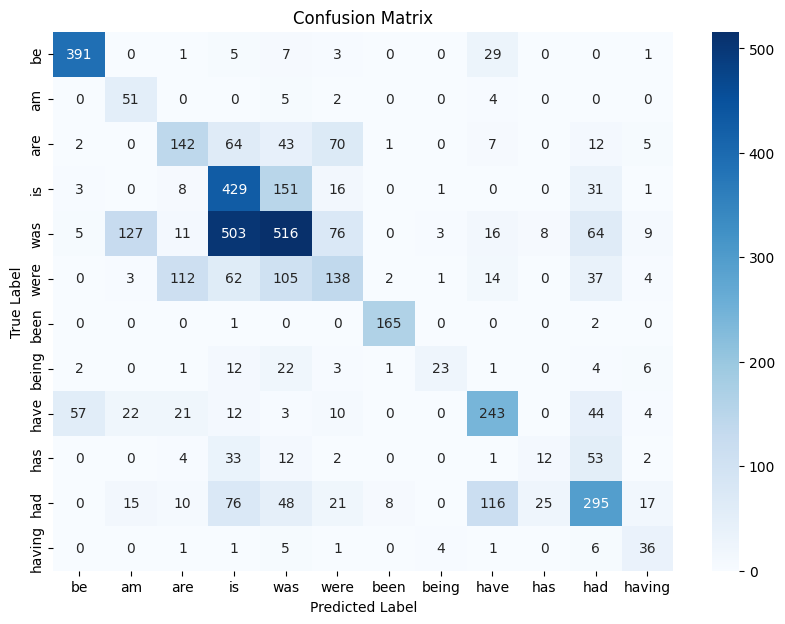

the best model on validation data was with MLP_200_128_4_0.001 and gave an accuracy of 18.571428571428573
the best model on test data gave an accuracy of 18.06925498426023


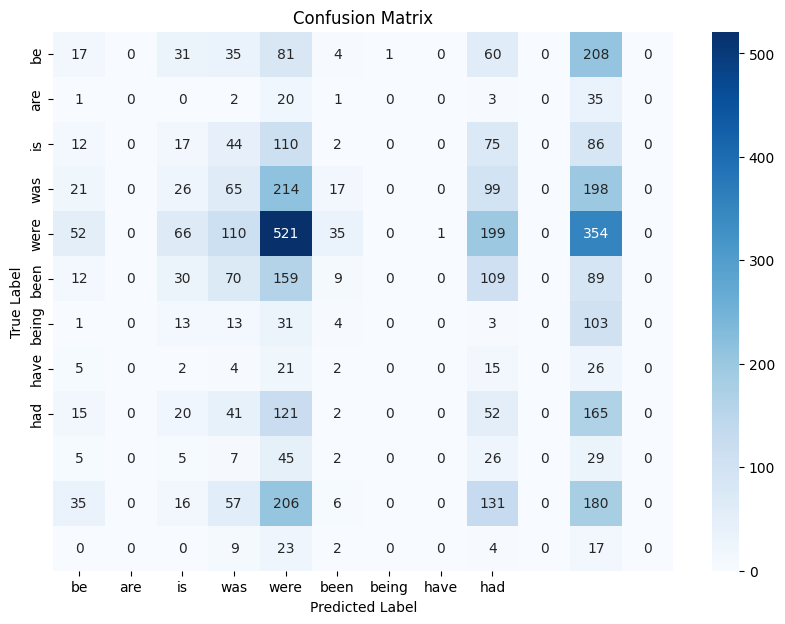

the best model on validation data was with 62560.40.001 and gave an accuracy of 66.98841698841699
the best model on test data gave an accuracy of 59.01364113326338


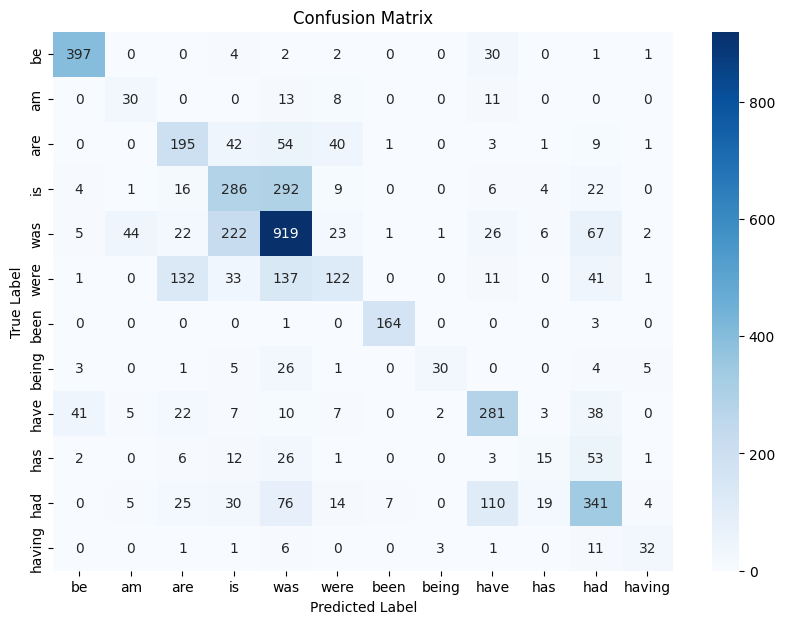

In [128]:
def create_conf_matrix(model):
    targ, pred, _,_= loss_validation(test_dataloader_3, model, criterion)
    itos = vocab.get_itos()
    all_preds_np = pred.numpy()
    all_labels_np = targ.numpy()
    classes_int = np.unique(all_preds_np)
    classes_int = [re_map[x] for x in classes_int]
    classes_str = [itos[int(x)] for x in classes_int]
    # Compute the confusion matrix

    conf_matrix = confusion_matrix(all_labels_np, all_preds_np)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d",
    xticklabels=classes_str, yticklabels=classes_str, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
create_conf_matrix(check_performance_SIMPLE_MLP())
create_conf_matrix(check_performance_MLP())
create_conf_matrix(check_performance_LSTM())



# 3.1 creating dataset

In [156]:
# context size for this task 
CONTEXT_SIZE = 6


# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        # Word used to define target
        t = txt[i + context_size]
        
        # Context before the target
        c = txt[i:i + context_size]
        
        if len(c) == 6:
            targets.append(t)
            contexts.append(torch.tensor(c))
            
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)
    

In [157]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train = load_dataset(words_train, vocab, "data_train_LSTM.pt")
data_val = load_dataset(words_val, vocab, "data_val_LSTM.pt")
data_test = load_dataset(words_test, vocab, "data_test_LSTM.pt")

## 3.2 LSTM network

In [158]:
class MyNet(nn.Module):
    """
    Simple net with only one LSTM layer and one fc layer. 
    
    The LSTM layer can be ``MyLSTM`` or ``nn.LSTM``
    """
    def __init__(
        self,
        hidden_size:int,
        embedding=None, 
    ):
        
        super().__init__()
        
        (vocab_size, embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False

            
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        # LSTM outputs: (out, (h, c)) with h of shape (num_layer, N, H_out) and we want h[-1,:,:]
        output, (h_n, c_n) = self.lstm(x)
        out = self.fc1(h_n[-1, :, :])
        return out

## 3.3 Training and performance

In [160]:
device = torch.device('cpu')
#print(f"Training on device {device}.")


MODEL_FNAME = "model_LSTM.pt"


batch_size = 512
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

# These parameters don't matter much in this assignment
n_epochs = 30
lr = 0.001
hidden_size = 32

torch.manual_seed(265)
model = MyNet(hidden_size, embedding=embedding).to(device=device)     
    
if os.path.isfile(PATH_GENERATED + MODEL_FNAME):
    # Load the trained model
    model = torch.load(PATH_GENERATED + MODEL_FNAME)
    model.to(device)
else:
    # Or train the model...
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train(
        n_epochs = n_epochs,
        optimizer = optimizer, 
        model = model,
        loss_fn = loss_fn,
        train_loader = train_loader,
    )
    
    # ... and save it
    torch.save(model.to(device="cpu"), PATH_GENERATED + MODEL_FNAME)

acc_train = compute_accuracy(model, train_loader)
acc_val = compute_accuracy(model, val_loader)
acc_test = compute_accuracy(model, test_loader)
print("Training Accuracy:     %.4f" %acc_train)
print("Validation Accuracy:   %.4f" %acc_val)
print("Test Accuracy:   %.4f" %acc_test)


On device cpu.
On device cpu.
On device cpu.
Training Accuracy:     0.2367
Validation Accuracy:   0.2288
Test Accuracy:   0.2710


## 3.4 Beam search

In [161]:
# Converts sequence text into sequence of tokens/indicies
def text_to_sequence(text):
    text = text.split()
    text = [vocab[i] for i in text]
    return text

# Converts sequence of tokens/indicies to sequence of text
def sequence_to_text(seq):
    return [vocab.lookup_token(s) for s in seq]


In [165]:
# Beam away my friends
import copy


def beam_search(sequence, model, beam_width, max_sequence_length=None):
    model.eval()
    final_sequence = [[text_to_sequence(sequence), 0] for _ in range(beam_width)] # Make copies of original sequence equal to "Beam_width"
    sequence = text_to_sequence(sequence) # Convert text to indexes
    sequence = torch.tensor(sequence) # Transform to tensor
    sequence = sequence.unsqueeze(0) # Unsqueeze to fit the model
    sequence = model(sequence) # feed the model
    sequence = torch.softmax(sequence, dim=1) # Make probabilites from model output
    scores, scores_indices = torch.sort(sequence, dim=1, descending=True) # Sort the probabilites descending
    scores = scores.squeeze(1)
    sequence = torch.argsort(sequence, dim=1, descending=True) # Sort the indexes descending
    for i in range(beam_width): # Add k best option to k-th list with score
        final_sequence[i][0].append(int(sequence[0][i]))
        final_sequence[i][1] = float((scores[0][i]))
    
    # Feed model with new k-sequences 
    actual_final = []
    for max_length in range(1, max_sequence_length): # Repeat until "max_sequence_length" is reached
        for j, sequence in enumerate(final_sequence): # Feed the k different lists to the model
            sequence = torch.tensor(sequence[0])
            sequence = sequence.unsqueeze(0)
            sequence = model(sequence)
            sequence = torch.softmax(sequence, dim=1)
            scores, scores_indices = torch.sort(sequence, dim=1, descending=True)
            scores = scores.squeeze(1)
            sequence = torch.argsort(sequence, dim=1, descending=True)
            temp_sequence = [copy.deepcopy(final_sequence[j]) for _ in range(beam_width)] # Save k temporary copies of current list
            for k in range(len(temp_sequence)): # Append k best results to current list
                temp_sequence[k][0].append(int(sequence[0][k]))
                temp_sequence[k][1] *= float(scores[0][k])
                actual_final.append(copy.deepcopy(temp_sequence[k])) # Append all results to "actual_final". Which will later sort out the k best options
        actual_final = sorted(actual_final, key=lambda x: x[1], reverse=True) # Sort all results
        final_sequence = copy.deepcopy(actual_final[:beam_width]) # Only keep best k options (k = "beam_width")
        actual_final = [] # Repeat above steps until "max_sequence_length" is reached
    

    word_result = [] # Transform token indicies to words
    for sequence in final_sequence:
        word_result.append([sequence_to_text(copy.deepcopy(sequence[0])), sequence[1]])
    return final_sequence, word_result # Returns results as token indicies with score (final_sequence), and as words with score (word_result)

In [166]:
# Crates new sequence with results from beam search
def append_result(sequence, token_sequence):
    sequence = [[" ".join(ele[0]), ele[1]] for ele in sequence]
    for i in sequence:
        print(i)
    for j in token_sequence:
        print(j)
    return sequence

In [167]:
# Type in whatever sequence you want
seq = "the house were"

# Run beam search
search, words = beam_search(seq, model, beam_width=5, max_sequence_length=5)

# Print results
result = append_result(words, search)

['the house were <unk> to the <unk> of', 0.0003493775321344606]
['the house were <unk> in the <unk> of', 0.00034223183423138907]
['the house were <unk> to the <unk> ,', 0.0002804756357495435]
['the house were <unk> in the <unk> ,', 0.0002660973115670801]
['the house were <unk> to the <unk> .', 0.00023668073669512997]
[[2, 150, 41, 0, 6, 2, 0, 5], 0.0003493775321344606]
[[2, 150, 41, 0, 8, 2, 0, 5], 0.00034223183423138907]
[[2, 150, 41, 0, 6, 2, 0, 1], 0.0002804756357495435]
[[2, 150, 41, 0, 8, 2, 0, 1], 0.0002660973115670801]
[[2, 150, 41, 0, 6, 2, 0, 3], 0.00023668073669512997]
